In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from copy import deepcopy
from tqdm import notebook, tqdm
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, ParameterGrid, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [2]:
pd.options.display.expand_frame_repr = False
pd.set_option('display.max_columns', None)

## 1. Загрузка данных

Так как в каждом файле есть столбец `customerID` - уникальный идентификатор клиента - используем его в качестве индекса при загрузке всех четырех датасетов

#### Файл "personal.csv"
Персональные данные клиента

In [3]:
personal = pd.read_csv('datasets/final_provider/personal.csv', index_col='customerID')
print(personal.info())
personal

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB
None


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes
2234-XADUH,Female,0,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes


Файл содержит следующие столбцы:
- gender - пол (Male/Female)
- SeniorCitizen - пожилой (0 - да / 1 - нет)
- Partner - имеется ли партнер, по всей видимости муж/жена (Yes/No)
- Dependents - имеется ли кто-либо на иждивении (Yes/No)

Пропусков нет.

Видно, что все столбцы, категориальные, но записаны по-разному: 1/0 или Yes/No. Дальше данные нужно будет преобразовать к логическому типу данных

Для удобства дальнейшей работы изменим форму написания столбца `gender`, чтобы название начиналось с большой буквы, как и у остальных столбцов.

In [4]:
personal.rename(columns={'gender': 'Gender'}, inplace=True)
personal

,Gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes
2234-XADUH,Female,0,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes


На всякий случай проверим, не дублируются ли идентификаторы пользователей

In [5]:
print('Кол-во дубликатов:', personal.index.duplicated().sum())

Кол-во дубликатов: 0


Все в порядке, идентификаторы действительно уникальные.

#### Файл "contract.csv"
Информация о договоре

In [6]:
contract = pd.read_csv('datasets/final_provider/contract.csv', index_col='customerID')
print(contract.info())
print('\nКол-во дубликатов:', contract.index.duplicated().sum())
contract

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(6)
memory usage: 440.2+ KB
None

Кол-во дубликатов: 0


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45


Файл содержит следующие столбцы:
- BeginDate - дата начала договора (с точностью до месяца, всегда стоит первое число месяца)
- EndDate - дата окончания договора (если договор продолжается, стоит значение "No")
- Type - тип контракта (годовой, двухгодовой или обновляемый каждый месяц)
- PaperlessBilling - выставляется ли электронный счет 
- PaymentMethod - способ оплаты (электронный чек, бумажный чек, кредитная карта, банковский перевод)
- MonthlyCharges - величина ежемесячного платежа
- TotalCharges - суммарный платеж - по всей видимости имеется в виду сумма, заплаченная за все время

Пропуски и дубликаты отсутствуют

Данные в столбцах `BeginDate` и `EndDate` - строки, а не даты  
Данные в столбце `TotalCharges` - строки, а не числа  
Столбец `PaperlessBilling` лучше перевести к логическому типу данных.

#### Файл "internet.csv"
Информация об интернет-услугах

In [7]:
internet = pd.read_csv('datasets/final_provider/internet.csv', index_col='customerID')
print(internet.info())
print('\nКол-во дубликатов:', internet.index.duplicated().sum())
internet

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(7)
memory usage: 344.8+ KB
None

Кол-во дубликатов: 0


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...
6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
4801-JZAZL,DSL,Yes,No,No,No,No,No


Пропусков и дубликатов нет, но строк меньше, чем общее количество клиентов. Это вполне допустимо: часть клиентов может пользоваться только услугами телефонии, тогда их данных нет в датасете для интернет-услуг.

Имеются следущие столбцы:
- InternetService - тип подключения (DSL или оптоволокно)
- OnlineSecurity - блокировка небезопасных сайтов (Yes/No)
- OnlineBackup - облачное хранилище (Yes/No)
- DeviceProtection - антивирус (Yes/No)
- TechSupport - выделенная линия техподдержки (Yes/No)
- StreamingTV - стриминговое телевидение (Yes/No)
- StreamingMovies - каталог фильмов (Yes/No)

Столбцы OnlineSecurity...StreamingMovies лучше перевести к логическому типу данных.

#### Файл "phone.csv"
Информация об услугах телефонии

In [8]:
phone = pd.read_csv('datasets/final_provider/phone.csv', index_col='customerID')
print(phone.info())
print('\nКол-во дубликатов:', phone.index.duplicated().sum())
phone

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
MultipleLines    6361 non-null object
dtypes: object(1)
memory usage: 99.4+ KB
None

Кол-во дубликатов: 0


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
...,...
2569-WGERO,No
6840-RESVB,Yes
2234-XADUH,Yes


Пропусков и дубликатов нет, но количество строк меньше, чем в остальных файлах. Ситуация аналогична файлу internet.csv: часть клиентов может пользоваться только услугами интернета, тогда их данных нет в датасете для телефонии.  
Имеется всего один столбец `MultipleLines` - подключен ли телефонный аппарат к нескольким линиям одновременно. Этот столбец лучше привести к логическому типу данных.

## 2. Объединение данных
Для удобства дальнейшей работы объединим данные из четырех файлов в один датафрейм. При этом введем два дополнительных логических столбца с информацей о том, пользуется ли клиент услугами телефонии и интернетом. Пропуски, получившиеся из-за того, что в файлах internet и phone есть записи не обо всех клиентах, заполним чуть позже, после анализа данных.

In [9]:
telecom = contract.join(personal)
telecom = telecom.join(internet)
telecom = telecom.join(phone)

telecom['Internet'] = telecom['InternetService'].notnull()
telecom['Phone'] = telecom['MultipleLines'].notnull()
print(telecom.info())
telecom

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
Internet            7043 non-null bool
Phone               7043 non-null bool
dtypes: bool(2), float64(1

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,True,False
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,True,True
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,True,True
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,True,False
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,True,True
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,True,True
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN,True,False


## 3. Преобразование типов

Приведем столбцы `BeginDate` и `EndDate` к типу данных datetime. Для столбца `EndDate`, в котором есть значения "No", укажем парамер `errors='coerce'`, кроме того, уберем ненужные данные о времени. В результате преобразования в этом столбце появятся пропуски, на основании которых мы дальше сформируем целевой признак, а сам столбец не будем включать в состав признаков для модели.

In [10]:
telecom['BeginDate'] = pd.to_datetime(telecom['BeginDate'])
telecom['EndDate'] = pd.to_datetime(telecom['EndDate'], errors='coerce').dt.round('1D')

Приведем столбец `TotalCharges` к типу данных float. В столбце встречаются пустые значения (" "), которые мешают преобразованию, поэтому укажем парамер `errors='coerce'`. После этого просмотрим строки, с которыми возникли проблемы.

In [11]:
telecom['TotalCharges'] = pd.to_numeric(telecom['TotalCharges'], errors='coerce')
telecom['TotalCharges'].fillna(0, inplace=True)

Пока что только заменим значения 0/1 в столбце `SeniorCitizen` на No/Yes, чтобы запись была одинаковой.

In [12]:
telecom['SeniorCitizen'].replace([0, 1], ['No', 'Yes'], inplace=True)

Здесь же для компактности записи уберем "(automatic)" из столбца `PaymentMethod`

In [13]:
telecom['PaymentMethod'].replace(['Bank transfer (automatic)', 'Credit card (automatic)'], 
                                 ['Bank transfer', 'Credit card'], inplace=True)

Посмотрим на получившийся датасет

In [14]:
telecom

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,Phone
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN,True,False
5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,True,True
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,True,True
7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer,42.30,1840.75,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,True,False
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,Male,No,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,True,True
2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card,103.20,7362.90,Female,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,True,True
4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,Female,No,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN,True,False


## 3. Исследование данных

Первым делом сформируем стобец `Loss`, который станет целевым признаком для модели. Его значение определяется тем, указана ли дата окончания контракта в столбце `EndDate`.

In [15]:
telecom['Loss'] = telecom['EndDate'].notnull()
print('Процент ухода: %.1f%%' % (telecom['Loss'].sum()/len(telecom)*100))

Процент ухода: 26.5%


Ушло чуть больше четверти клиентов - совсем не мало.

Чтобы посмотреть, как распределены пользователи, пользующиеся интернетом и телефоном, введем столбец `Services`

In [16]:
telecom['Services'] = telecom['Internet'].astype(int) + telecom['Phone'].astype(int)*2
telecom['Services'].replace([0,1,2,3], ['Nothing', 'Internet', 'Phone', 'Internet+Phone'], inplace=True)

Посмотрим на соотношения в столбцах. Для компактности и наглядности представления категориальных данных построим графики типа pieplot, для этого введем функцию plot_pies

In [17]:
def plot_pies(data, pie_rows=1):
    pie_cols = np.ceil(len(data.columns)/pie_rows)
    plt.figure(figsize=(16,pie_rows*4))
    for i in range(len(data.columns)):
        ax = plt.subplot(pie_rows, pie_cols, i+1)
        col = data.columns[i]
        table = data[col].value_counts()
        ax.pie(table, labels=table.index, autopct='%1.1f%%')
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.set_title(col)
    plt.show()

#### Данные контракта

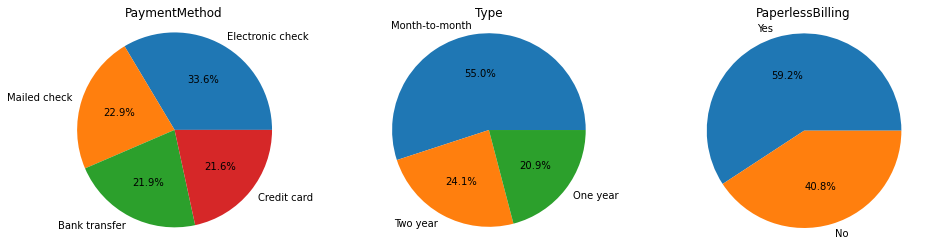

In [18]:
plot_pies(telecom[['PaymentMethod', 'Type', 'PaperlessBilling']])

По способу оплаты более популярен электронный чек (33,6%), оставльные варианты практически равнозначны.  
Большая часть клиентов (55%) продляет договор от месяца к месяцу, четверть заключила договора на два года - видимо так дешевле.  
Почти 60% клиентов выбрали электронный счет вместо бумажного - вполне возможно.  
Ничего не режет глаз, переходим к следующему набору данных.

#### Данные клиентов

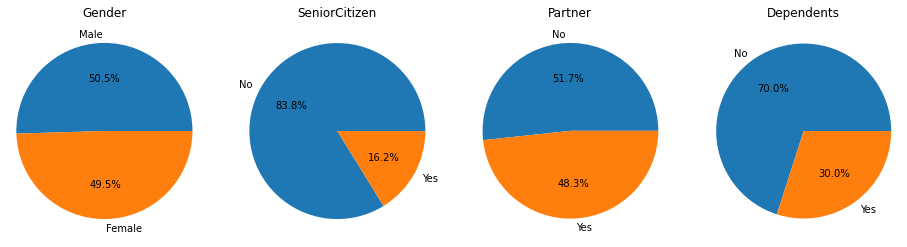

In [19]:
plot_pies(telecom[['Gender', 'SeniorCitizen', 'Partner', 'Dependents']])

Мужчин и женщин среди клиентов почти поровну, это ожидаемо.  
Пожилых клиентов около 16% - вполне правдоподобно, примерно соответствует доле людей старше 65 лет от всего населения РФ.  
Чуть меньше половины клиентов имеют партнера, т.е. женаты или замужем. Это тоже соответствует статистике.  
Клиентов, у которых есть кто-то на иждивении, ровно 30% - это не так интуитивно понятно. Можно предположить, что под иждивенцами чаще всего понимаются несовершеннолетние дети. Тогда должна прослеживаться связь между столбцами `Partner` и `Dependents`. Проверим это.

In [20]:
print('Клиенты с партнерами:', len(telecom.query('Partner=="Yes"')))
print('Клиенты с партнерами:', len(telecom.query('Dependents=="Yes"')))
print('Клиенты с партнерами:', len(telecom.query('Partner=="Yes" & Dependents=="Yes"')))

Клиенты с партнерами: 3402
Клиенты с партнерами: 2110
Клиенты с партнерами: 1749


Действительно, половина клиентов с партнерами имеет кого-то на иждивении, при этом большая часть клиентов с иждивенцами имеет партнеров. Полученный результат укладывается в логику, значит можно сделать вывод, что данные в столбце `Dependents` выглядят правдоподобно.

#### Данные об услугах интернета и телефонии

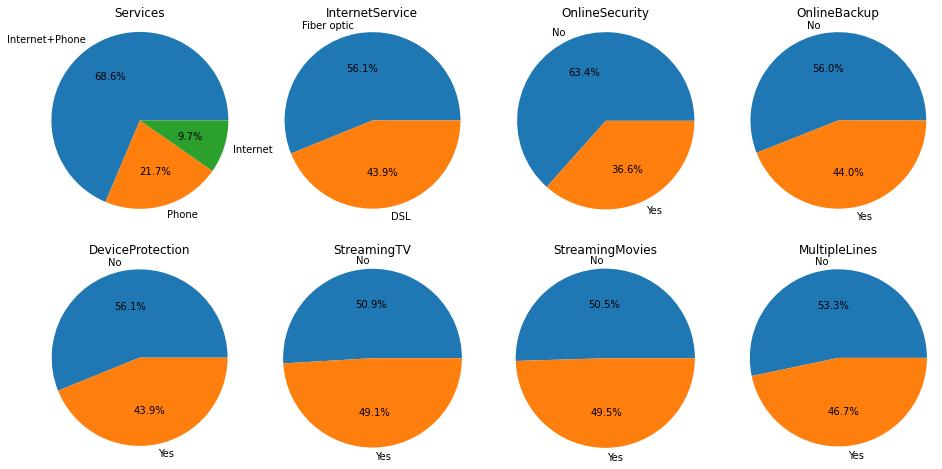

In [21]:
plot_pies(telecom[['Services', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'StreamingTV', 'StreamingMovies', 'MultipleLines']], 2)

Почти 70% клиентов пользуется и телефоном, и интернетом, только телефоном - 21,7%, только интернетом - 9,7%. Клиентов без услуг нет, эту возможную ошибку исключили.  
Оптоволокна больше, чем DSL - в 2020 году это ожидаемо.  
В остальных столбцах сложно проконтролировать правдоподобность данных, по крайней мере убедились, что встречаются только значения Yes, No и введенное нами NA.

#### Данные о заключении и расторжении договоров

In [22]:
print('Приход:')
print('first date:', telecom['BeginDate'].min())
print('last date: ', telecom['BeginDate'].max())
print('\nУход:')
print(telecom['EndDate'].value_counts(sort=False))

Приход:
first date: 2013-10-01 00:00:00
last date:  2020-02-01 00:00:00

Уход:
2019-12-01    466
2020-01-01    460
2019-10-01    458
2019-11-01    485
Name: EndDate, dtype: int64


Представлены данные о договорах, заключенных с октября 2013 года до февраля 2020.  
Странно то, что нет данных об уходе клиентов ранее октября 2019 года: сложно представить, что за первые 6 лет работы компании не ушел ни один клиент. Тимлид пояснил, что до этого момента у провайдера не было сильных конкурентов, и учет уходов не велся. Видимо, данные о закрытом договоре просто удалялись из базы.  
Построим график, показывающий распределение прихода клиентов по времени, и сколько из них ушло к настоящему моменту.

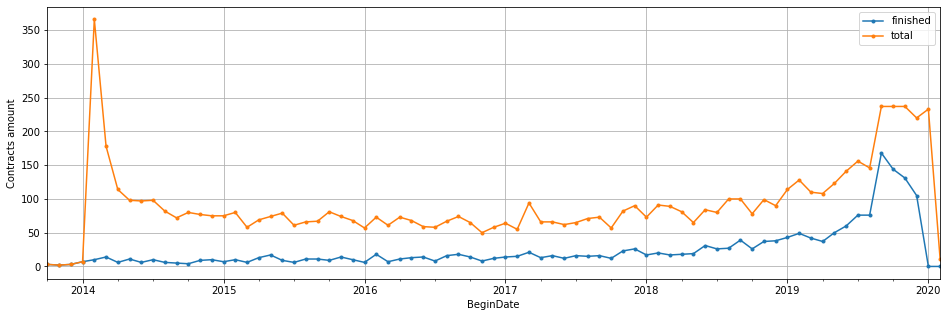

In [23]:
date_table = telecom.pivot_table(index='BeginDate', values=['Type','EndDate'], aggfunc='count')
date_table.columns = ['finished','total']
date_table.plot(figsize=(16,5), style='.-')
plt.ylabel('Contracts amount')
plt.grid()
plt.show()

На графике виден взрывной приток пользователей в начале 2014 года, затем стабильный прирост в течение пяти лет и новый рост с начала 2019 года. В абсолютном исчислении количество уходящих пользователей медленно растет, но есть скачок уходов в 2019 году, который совпадает со скачком новых клиентов. Но больше выводов можно сделать, если вывести на отдельный график процент ухода. 

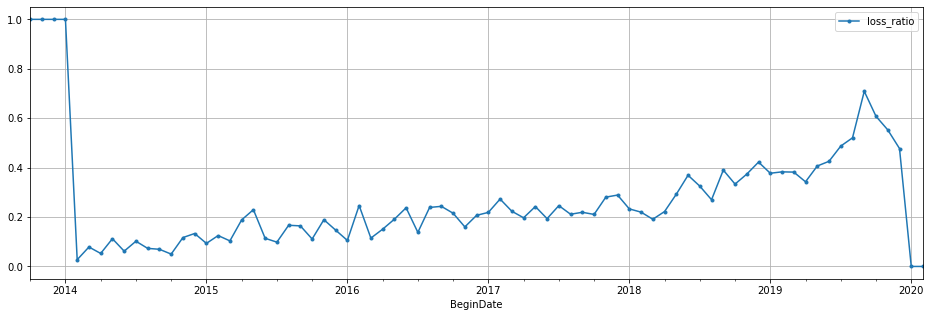

In [24]:
date_table['loss_ratio'] = date_table['finished']/date_table['total']
date_table[['loss_ratio']].plot(figsize=(16,5), style='.-')
plt.grid()
plt.show()

Следует обратить внимание на два нерелевантных периода, в начале и в конце, которые лучше исключить из датасета.  
До января 2014 года включительно клиентов было очень мало, и при этом все они ушли, что выбивается из общей статистики.  
Для клиентов, пришедших в феврале 2020 года, прошло слишком мало времени до текущего момента, чтобы сделать вывод об их уходе. 
График позволяет сделать еще и такой вывод: старые клиенты наиболее лояльные (всего около 10% уходов для клиентов 2014 года), пришедшие недавно - с большой вероятностью склонны уйти (больше 40% для 2019 года). Получается, что время, прошедшее с момента заключения договора - очень важный параметр для модели, введем его в новом столбце `ContractAge`. Учитывая, что даты начала и окончания договоров привязаны к началу месяца, логично выразить столбец ContractAge в месяцах.

In [25]:
telecom = telecom.query('BeginDate>@dt.datetime(2014,1,1) and BeginDate<@dt.datetime(2020,2,1)')
telecom['ContractAge'] = telecom['EndDate'].fillna(dt.datetime(2020,2,1)) - telecom['BeginDate']
telecom['ContractAge'] = telecom['ContractAge'].astype('timedelta64[D]')
telecom['ContractAge'] = (telecom['ContractAge']/30).astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Построим аналогичные графики для нового столбца

In [26]:
def plot_ContractAges(column):
    date_table = telecom.pivot_table(index=column, values=['Type','EndDate'], aggfunc='count')
    date_table.columns = ['finished','total']
    date_table.plot(figsize=(16,3), style='.-')
    plt.ylabel('Contracts amount')
    plt.grid()
    plt.show()
    date_table['loss_ratio'] = date_table['finished']/date_table['total']
    date_table[['loss_ratio']].plot(figsize=(16,3), style='.-')
    plt.grid()
    plt.show()
    print(date_table['loss_ratio'].head(10))

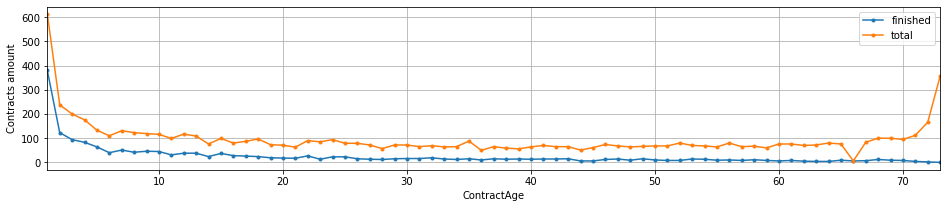

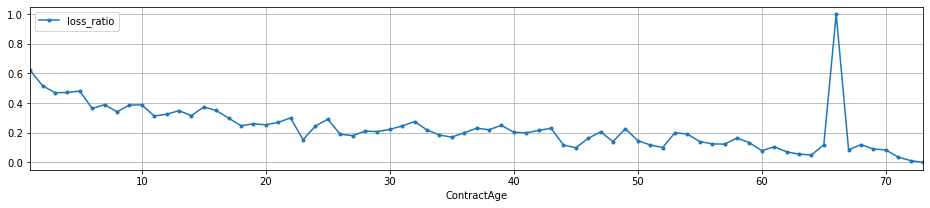

ContractAge
1     0.619902
2     0.516807
3     0.470000
4     0.471591
5     0.481203
6     0.363636
7     0.389313
8     0.341463
9     0.386555
10    0.387931
Name: loss_ratio, dtype: float64


In [27]:
plot_ContractAges('ContractAge')

Прослеживается четкая зависимость, которая должна помочь обучить модель. Но последующая работа показала, что значительно более высокую точность можно получить, если выразить этот столбец в днях.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


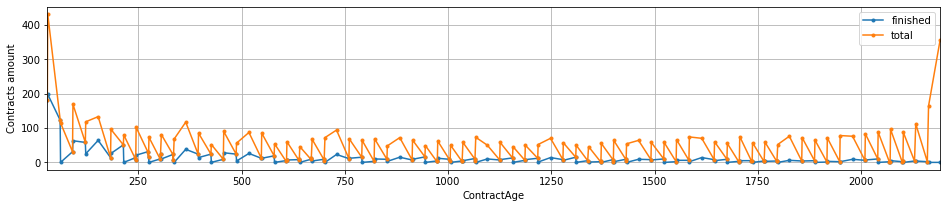

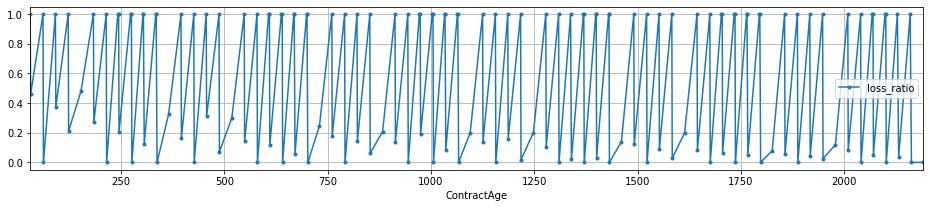

ContractAge
30.0     1.000000
31.0     0.459397
61.0     1.000000
62.0     0.000000
91.0     1.000000
92.0     0.372781
122.0    1.000000
123.0    0.211864
153.0    0.481203
183.0    1.000000
Name: loss_ratio, dtype: float64


In [28]:
telecom['ContractAge'] = telecom['EndDate'].fillna(dt.datetime(2020,2,1)) - telecom['BeginDate']
telecom['ContractAge'] = telecom['ContractAge'].astype('timedelta64[D]')
plot_ContractAges('ContractAge')

Природа колебаний на графике мне не ясна, но очевидно, что они оказывают более сильное влияние на модель, чем линейная зависимость, в которой фактически усредняются соседние точки, относящиеся к одному месяцу. Модель должна стать сложнее, чтобы выучить такую сложную нелинейную зависимость, за счет чего и достигается более высокое качество прогноза.

#### Данные о платежах
Для удобства представления данных введем функцию `plot_histbox`, которая выведет на одном графике гистограмму и ящик с усами

In [29]:
def plot_histbox(data):
    
    f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.85, .15)})

    # Add a graph in each part
    sns.distplot(data, ax=ax_hist, norm_hist=False, bins=20)
    sns.boxplot(data, ax=ax_box)

    # Remove x axis name for the boxplot
    ax_hist.set(xlabel='')
    ax_hist.grid()
    ax_box.grid()

Построим график для ежемесячных платежей

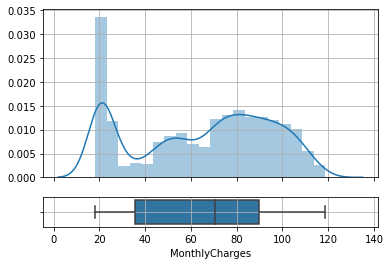

In [30]:
plot_histbox(telecom['MonthlyCharges'])

На гистограмме видно три участка: пик на 20, маленький горб в районе 45-60 и большой горб в районе 70-110. Можно предположить, что так проявляются различия в ежемесячной плате трех категорий клиентов: тех, кто пользуется только телефоном, только интернетом и обоими сервисами одновремено. Проверим это, построив распределение для каждой категории в отдельности.

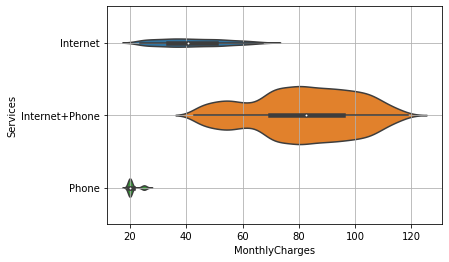

In [31]:
ax = sns.violinplot(x='MonthlyCharges', y='Services', data=telecom, orient='h', scale='count')
ax.grid()
plt.show()

Действительно, данные по оплате сгруппированы в зависимости от используемых сервисов. Причем на распределении для телефонии виден еще один пик справа, характерный для тех, кто пользуется услугой мультилинии. А разделение основной части гистограммы на два горба соотвтетствует стоимости доступа в интернет через DSL и оптоволокно, что видно на рисунке ниже

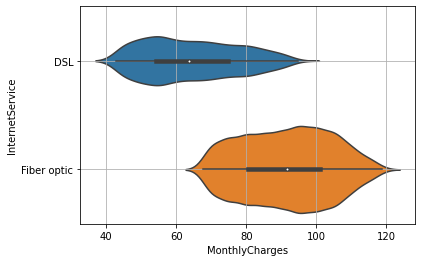

In [32]:
ax = sns.violinplot(x='MonthlyCharges', y='InternetService', 
                    data=telecom.query('Services=="Internet+Phone"'), orient='h', scale='count')
ax.grid()
plt.show()

Суммарные платежи

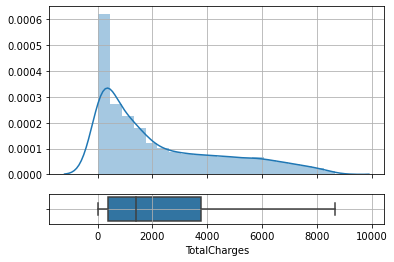

In [33]:
plot_histbox(telecom['TotalCharges'])

Чем больше значение, тем реже встречается - это ожидаемо с учетом того, что количество клиентов постоянно растет. В целом этот столбец не несет никакой новой информации с учетом того, что у нас есть размер ежемесячной платы и возраст договора. Не вижу смысла включать его в перечень параметров для модели.

#### Сравнение распределений для ушедших и оставшихся клиентов

Ежемесячные платежи ушедших и оставшихся клиентов нужно сравнивать с учетом разбивки по категориям.

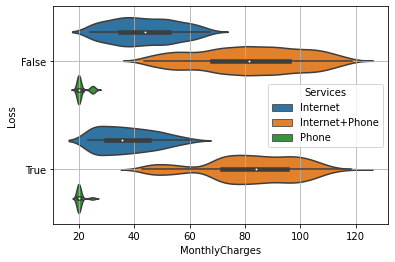

In [34]:
ax = sns.violinplot(x='MonthlyCharges', y='Loss', hue='Services', orient='h', data=telecom, scale='width')
ax.grid()
plt.show()

У клиентов, пользующихся только телефоном плата одинаковая, различий там не увидеть в принципе. В других категориях различия не столь явные. Может быть, эффективнее сравнение по типу Интернет-соединения.

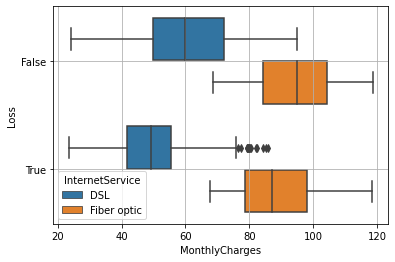

In [35]:
ax = sns.boxplot(x='MonthlyCharges', y='Loss', hue='InternetService', orient='h', data=telecom)
ax.grid()
plt.show()

Интересный вывод: в каждой из категорий чаще уходят клиенты с низкими платежами. Можно предположить, что конкурент предлагает выгодные условия тем, кому не важны дополнительные сервисы.

Чтобы оценить, какие из категориальных параметров важны для прогноза ухода, сравним их распределения для ушедших (Lost) и оставшихся (Valid) клиентов. Введем функцию `plot_loss_depends`, которая автоматизирует вывод графиков для нескольких столбцов.

In [36]:
def plot_loss_depends(data, columns):
    
    plot_cols = 3
    plot_rows = np.ceil(len(columns)/plot_cols)    
    plt.figure(figsize=(16,plot_rows*4))
    
    for i in range(len(columns)):
        ax = plt.subplot(plot_rows, plot_cols, i+1)
        col = columns[i]
        table = pd.DataFrame()
        table['Lost'] = data.query('Loss')[col].value_counts(normalize=True)
        table['Valid'] = data.query('not Loss')[col].value_counts(normalize=True)
        table.plot(kind='bar', ax=ax)
        ax.grid()
        if len(table.index)>3:
            plt.xticks(rotation=45)
        else:
            plt.xticks(rotation=0)
        plt.title(col)   
    plt.show()

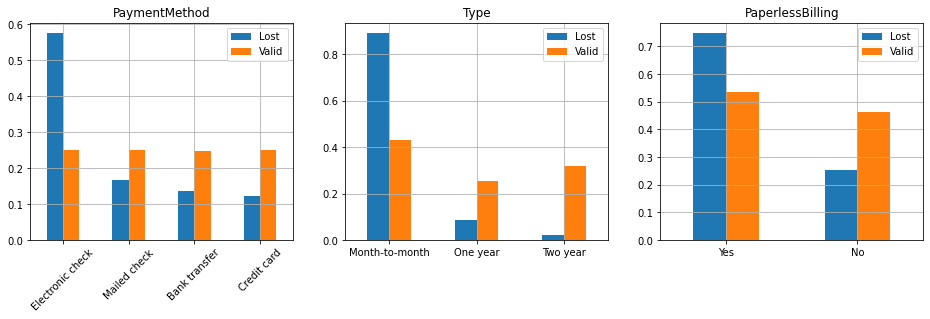

In [37]:
plot_loss_depends(telecom, ['PaymentMethod', 'Type', 'PaperlessBilling'])

Чаще остальных уходят те, кто пользуются электронным чеком и электронным счетом - не очень понятно, это первопричина или следствие каких-то других, пока скрытых, закономерностей.  
А вот то, что часто уходят клиенты, заключившие краткосрочный договор - это вполне ожидаемо.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matpl

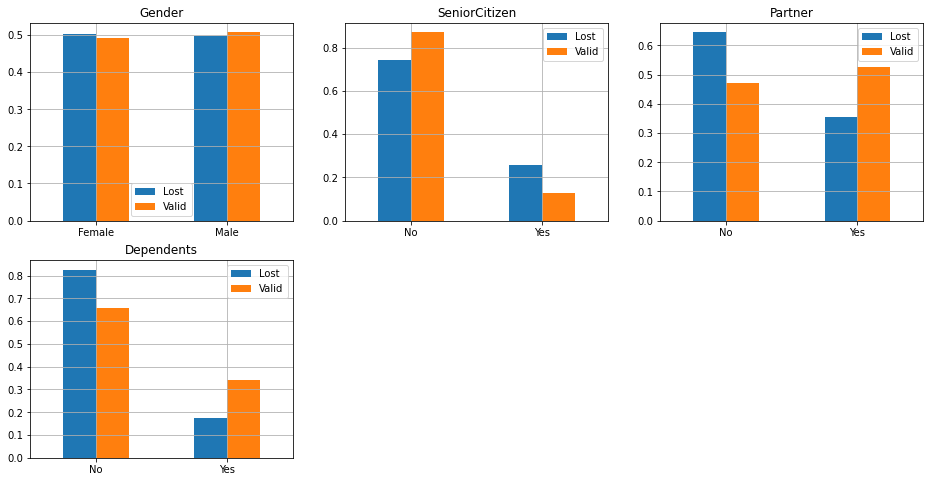

In [38]:
plot_loss_depends(telecom, ['Gender', 'SeniorCitizen', 'Partner', 'Dependents'])

Пол не влияет на вероятность ухода.  
Среди ушедших клиентов выше доля пожилых и ниже доля женатых и с детьми.

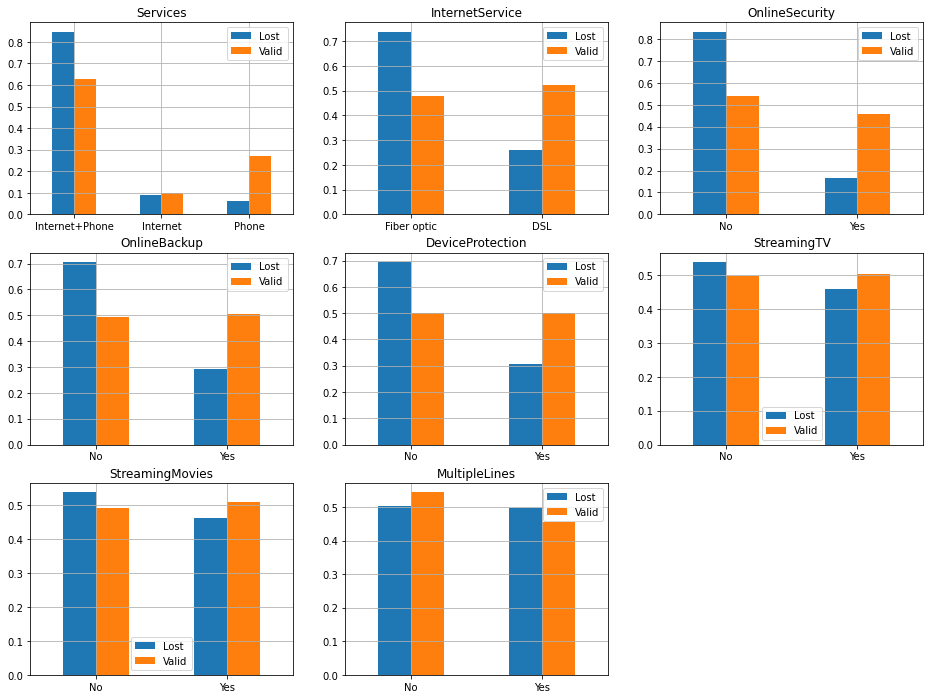

In [39]:
plot_loss_depends(telecom, ['Services', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'StreamingTV', 'StreamingMovies', 'MultipleLines'])

Чаще уходят клиенты, сидящие на оптоволокне. Реже - пользующиеся антивирусом, облачным хранилищем и блокировкой сайтов.  
Также редко уходят те, кто пользуются только телефоном и не пользуются Интернетом.

## 4. Подготовка данных для модели

Столбец EndDate, с использованием которого был сформирован целевой признак и одна фича, можно убрать из выборки - он больше не понадобится. Оставшиеся в данных пропуски удалим, заполнив их значением No (услуга не используется).

In [40]:
try:
    telecom = telecom.drop(['EndDate'], axis=1)
except:
    print('Already droped EndDate')
telecom = telecom.fillna('No')
print(telecom.info())
telecom.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7017 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 23 columns):
BeginDate           7017 non-null datetime64[ns]
Type                7017 non-null object
PaperlessBilling    7017 non-null object
PaymentMethod       7017 non-null object
MonthlyCharges      7017 non-null float64
TotalCharges        7017 non-null float64
Gender              7017 non-null object
SeniorCitizen       7017 non-null object
Partner             7017 non-null object
Dependents          7017 non-null object
InternetService     7017 non-null object
OnlineSecurity      7017 non-null object
OnlineBackup        7017 non-null object
DeviceProtection    7017 non-null object
TechSupport         7017 non-null object
StreamingTV         7017 non-null object
StreamingMovies     7017 non-null object
MultipleLines       7017 non-null object
Internet            7017 non-null bool
Phone               7017 non-null bool
Loss                7017 non-null bool
Services          

,BeginDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Internet,Phone,Loss,Services,ContractAge
customerID,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No,True,False,False,Internet,31.0
5575-GNVDE,2017-04-01,One year,No,Mailed check,56.95,1889.50,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,True,True,False,Internet+Phone,1036.0
3668-QPYBK,2019-10-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,True,True,True,Internet+Phone,61.0
7795-CFOCW,2016-05-01,One year,No,Bank transfer,42.30,1840.75,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No,True,False,False,Internet,1371.0
9237-HQITU,2019-09-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,True,True,True,Internet+Phone,61.0


Сформируем фичи и целевой признак.  
Из введенных для удобства анализа даных столбцов Services, Internet и Phone в состав признаков имеет смысл включить только столбец Phone. На наличие или отсутствие услуги доступа в Интернет уже указывает значение признака InternetService (если No - нет услуги), а Services - это просто комбинация Internet и Phone.  
Сразу выполним OHE-кодирование категориальных признаков

In [41]:
feature_cols = ['Type',
                'ContractAge','MonthlyCharges',
                'SeniorCitizen', 'Partner', 'Dependents', 'Gender',
                'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
                'Phone', 'MultipleLines']
num_cols = ['ContractAge','MonthlyCharges']

y = telecom['Loss']
X = telecom[feature_cols]
X = pd.get_dummies(X, drop_first=True)
print('Фичи:', X.shape)
print('Целевой признак: ', y.shape)
X.head()

Фичи: (7017, 18)
Целевой признак:  (7017,)


,ContractAge,MonthlyCharges,Phone,Type_One year,Type_Two year,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,Gender_Male,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,31.0,29.85,False,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,1036.0,56.95,True,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3668-QPYBK,61.0,53.85,True,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
7795-CFOCW,1371.0,42.30,False,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0
9237-HQITU,61.0,70.70,True,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Введем функции для корректной кросс-валидации и удобного отображения результатов подбора гиперпараметров

In [42]:
def train_valid_folds(features, target, folds=5):
    '''
    подготовка набора обучающих и валидационных выборок для кросс-валидации
    (чтобы экономить время в будущем)
    '''
    tt = []
    tf = []
    vt = []
    vf = []
    
    scaler = StandardScaler()
    kf = KFold(n_splits=folds)
    for train_index, valid_index in kf.split(target):
        
        cur_tt = target.iloc[train_index]
        cur_tf = features.iloc[train_index]
        cur_vt = target.iloc[valid_index]
        cur_vf = features.iloc[valid_index]
        
        # нормализация численных признаков
        cur_tf[num_cols] = scaler.fit_transform(cur_tf[num_cols])
        cur_vf[num_cols] = scaler.transform(cur_vf[num_cols])
        
        tt.append(cur_tt)
        tf.append(cur_tf)
        vt.append(cur_vt)
        vf.append(cur_vf)
        
    for i in range(folds):
        print('fold %d:' % i, tf[i].shape, tt[i].shape, vf[i].shape, vt[i].shape)
    return tf, tt, vf, vt

In [43]:
def plot_line2(x, y, y2, title='', xlabel='', ylabel=''):
    '''
    Функция выводит графики зависимости выбранных метрик исследуемой модели от значения гиперпараметра
    Входные параметры:
    - х - значения аргумента (гиперпараметра)
    - y - значения функции 1 (значения метрики на валидационной выборке)
    - y2 - значения функции 2 (значения метрики на обучающей выборке)
    - title - подпись графика (название модели)
    - xlabel - подпись оси Х (название изменяемого гиперпараметра)
    - ylabel - подпись оси Y
    '''
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x, y, marker='.', label='valid')
    ax.plot(x, y2, marker='.', label='train')
    ax.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [44]:
def plot_heatmap(x1, x2, y, title='', label=['','']):
    '''
    функция выводит график типа "heatmap" зависимости качества исследуемой модели от значений двух гиперпараметров
    х1 - значения гиперпараметра 1
    х2 - значения гиперпараметра 2
    y - значение метрики в виде одномерного массива (результат работы функции GridSearchCV.cv_results_['...'])
    title - название модели (подпись графика)
    label - массив с названиями двух гиперпараметров (подписи осей Х и Y)
    '''
    ysize = len(x1) if len(x1)<16 else 16
    xsize = len(x2) if len(x2)<16 else 16
    fig, ax = plt.subplots(figsize=(xsize,ysize))
    im = ax.imshow(y, cmap='coolwarm')
    plt.title(title)
    
    cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)

    ax.set_xticks(np.arange(len(x2)))
    ax.set_yticks(np.arange(-0.5,len(x1)))
    ax.set_xticklabels(x2)
    ax.set_yticklabels(x1)
    ax.set_xlabel(label[1])
    ax.set_ylabel(label[0])

    for i in range(len(x1)):
        for j in range(len(x2)):
            text = ax.text(j, i, y[i, j], ha="center", va="center", color="k", fontsize=8)
    plt.show()

In [45]:
def paramCV(model, data, params={}, name=''):
    '''
    кастомная кросс-валидация с перебором параметров (аналог GridSearchCV)
    '''
    
    scoring = 'ROC-AUC'
    
    # разбор data на набор X и y обучающей и валидационной выборок
    tf = data[0]
    tt = data[1]
    vf = data[2]
    vt = data[3]
    
    res = []
    res_train = []
    grid = ParameterGrid(params)
    pbar = notebook.tqdm(total=len(grid)*len(tf))
    
    # перебор сетки параметров
    for g in grid:
        model.set_params(**g)
        cv_res = []
        cv_res_train = []
        # перебор заранее созданного набора обучющих и валидационных выборок
        for i in range(len(tf)):
            model.fit(tf[i], tt[i])
            #valid_predicted = model.predict(vf[i])
            valid_proba = model.predict_proba(vf[i])[:,1]
            cv_res.append(roc_auc_score(vt[i], valid_proba))
            train_proba = model.predict_proba(tf[i])[:,1]
            cv_res_train.append(roc_auc_score(tt[i], train_proba))
            pbar.update() 
        res.append(np.round(np.mean(cv_res),3))
        res_train.append(np.round(np.mean(cv_res_train),3))
    pbar.close()
        
    # графики
    params_values = list(params.values())
    params_keys = list(params.keys())
    # линия для одного параметра
    if len(params_keys)==1:
        #plot_line(params_values[0], res, title=name, xlabel=params_keys[0], ylabel=scoring)
        plot_line2(params_values[0], res, res_train, title=name, xlabel=params_keys[0], ylabel=scoring)
    # тепловая карта для двух параметров
    elif len(params_keys)==2:
        len_p1 = len(params_values[0])
        len_p2 = len(params_values[1])
        res = np.reshape(res, (len_p1, len_p2))              
        plot_heatmap(params_values[0], params_values[1], res, title=name+' '+scoring, label=params_keys)
    elif len(params_keys)>2:
        print('grid_hparams: can\'t plot result')
    
    # отображение лучшего результата
    print('Best valid score:', np.max(res))
    print('Train score:', np.max(res_train))
    if len(params_keys) > 0:
        best_idx = np.argmax(res)
        print('Best params:', grid[best_idx])

    # запись лучшего результата в таблицу
    if name:
        result_table.loc[name,scoring] = np.max(res)

In [46]:
def print_feature_importance(model, features):
    '''
    вывод значимости признаков для деревянных моделей
    '''
    feature_importance = pd.DataFrame(index=features.columns)
    feature_importance['importance'] = model.feature_importances_
    print(feature_importance.sort_values('importance', ascending=False).round(3))

In [47]:
def print_lr_coefficients(model, features):
    '''
    вывод значимости признаков для логистической регрессии
    '''
    coefficients = pd.DataFrame(index=features.columns)
    coefficients['coef'] = model.coef_[0]
    coefficients['abs_coef'] = abs(coefficients['coef'])
    print(coefficients.sort_values('abs_coef', ascending=False).round(3))

Разобъем датасет на обучаующую и тестовую выборки в пропорции 4:1. Валидационную выборку выделять не будем, воспользуемся кросс-валидацией.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('Обучающая выборка:', X_train.shape, y_train.shape)
print('Тестовая выборка: ', X_test.shape, y_test.shape)

Обучающая выборка: (5613, 18) (5613,)
Тестовая выборка:  (1404, 18) (1404,)


Подготовка наборов обучающих и валидационных выборок для корректной кросс-валидации

In [49]:
train_data = train_valid_folds(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

fold 0: (4490, 18) (4490,) (1123, 18) (1123,)
fold 1: (4490, 18) (4490,) (1123, 18) (1123,)
fold 2: (4490, 18) (4490,) (1123, 18) (1123,)
fold 3: (4491, 18) (4491,) (1122, 18) (1122,)
fold 4: (4491, 18) (4491,) (1122, 18) (1122,)


## Подбор модели

Заготовка таблицы для записи результатов разных моделей

In [50]:
result_table = pd.DataFrame()

#### Логистическая регрессия

In [51]:
model = LogisticRegression(solver='lbfgs', random_state=123)
paramCV(model, train_data, name='LogisticRegression')
print_lr_coefficients(model, X_train)


Best valid score: 0.848
Train score: 0.851
                              coef  abs_coef
Type_Two year               -1.313     1.313
InternetService_No          -0.942     0.942
ContractAge                 -0.917     0.917
InternetService_Fiber optic  0.910     0.910
Type_One year               -0.803     0.803
Phone                       -0.564     0.564
OnlineSecurity_Yes          -0.540     0.540
TechSupport_Yes             -0.466     0.466
MultipleLines_Yes            0.318     0.318
StreamingTV_Yes              0.312     0.312
StreamingMovies_Yes          0.263     0.263
SeniorCitizen_Yes            0.223     0.223
OnlineBackup_Yes            -0.128     0.128
Dependents_Yes              -0.114     0.114
DeviceProtection_Yes        -0.081     0.081
MonthlyCharges               0.075     0.075
Partner_Yes                  0.066     0.066
Gender_Male                 -0.063     0.063


Логистическая регрессия с балансировкой классов

In [52]:
model = LogisticRegression(solver='lbfgs', class_weight='balanced', random_state=123)
paramCV(model, train_data, name='LogisticRegression balanced')


Best valid score: 0.847
Train score: 0.851


Логистическая регрессия сразу показывает неплохой результат - 0,848. Причем получен примерно одинаковый результат с балансировкой классов и без нее. Это объясняется тем, что в метрике ROC-AUC используются вероятности, а не предсказания, поэтому она оценивает качество модели вне зависимости от баланса данных. В дальнейшей работе балансировку использовать не будем.

#### kNN

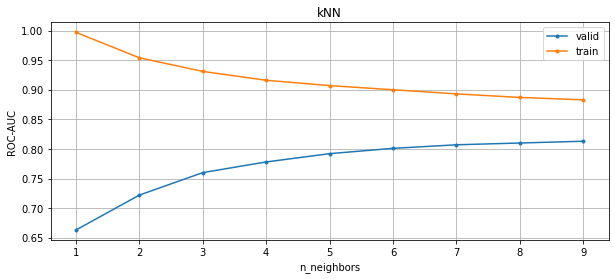

Best valid score: 0.813
Train score: 0.997
Best params: {'n_neighbors': 9}


In [53]:
model = KNeighborsClassifier()
params = {'n_neighbors': range(1,10)}
paramCV(model, train_data, params, name='kNN')

Соседи показали результат хуже, чем у регрессии

#### SVC

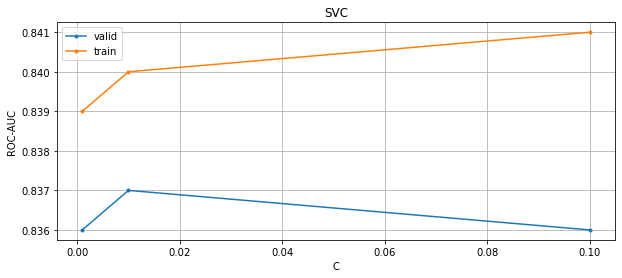

Best valid score: 0.837
Train score: 0.841
Best params: {'C': 0.01}


In [54]:
from sklearn.svm import SVC
model = SVC(gamma='auto', probability=True)
params = {'C': [0.001,0.01,0.1]}
paramCV(model, train_data, params, name='SVC')

SVC тоже показала не очень хороший результат

#### Дерево решений

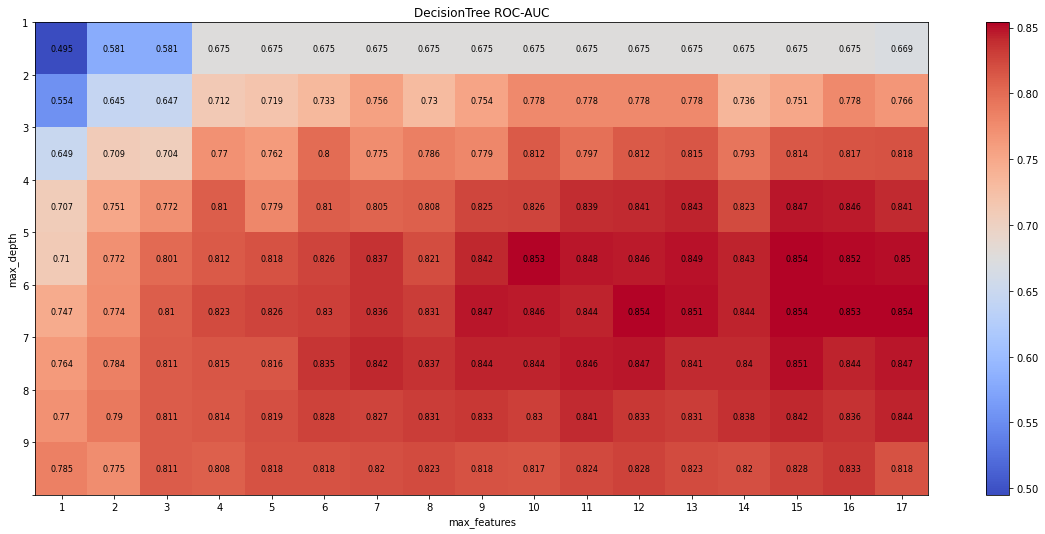

Best valid score: 0.854
Train score: 0.929
Best params: {'max_features': 15, 'max_depth': 5}
                             importance
ContractAge                       0.541
InternetService_Fiber optic       0.200
MonthlyCharges                    0.091
Type_Two year                     0.032
Type_One year                     0.028
InternetService_No                0.026
SeniorCitizen_Yes                 0.016
MultipleLines_Yes                 0.011
OnlineBackup_Yes                  0.008
OnlineSecurity_Yes                0.008
StreamingTV_Yes                   0.007
Gender_Male                       0.006
TechSupport_Yes                   0.006
Dependents_Yes                    0.005
Phone                             0.005
Partner_Yes                       0.005
StreamingMovies_Yes               0.004
DeviceProtection_Yes              0.002


In [55]:
model = DecisionTreeClassifier(random_state=123)
params = {'max_depth': range(1,10), 'max_features': range(1,X_train.shape[1])}
paramCV(model, train_data, params, name='DecisionTree')
print_feature_importance(model, X_train)

Дерево показало результат лучше, чем у регрессии. Посмотрим, что дадут ансамбли.

#### Случайный лес

Чтобы избежать переобучения, вначале определим оптимальную глубину дерева и количество признаков на небольшом количестве деревьев.

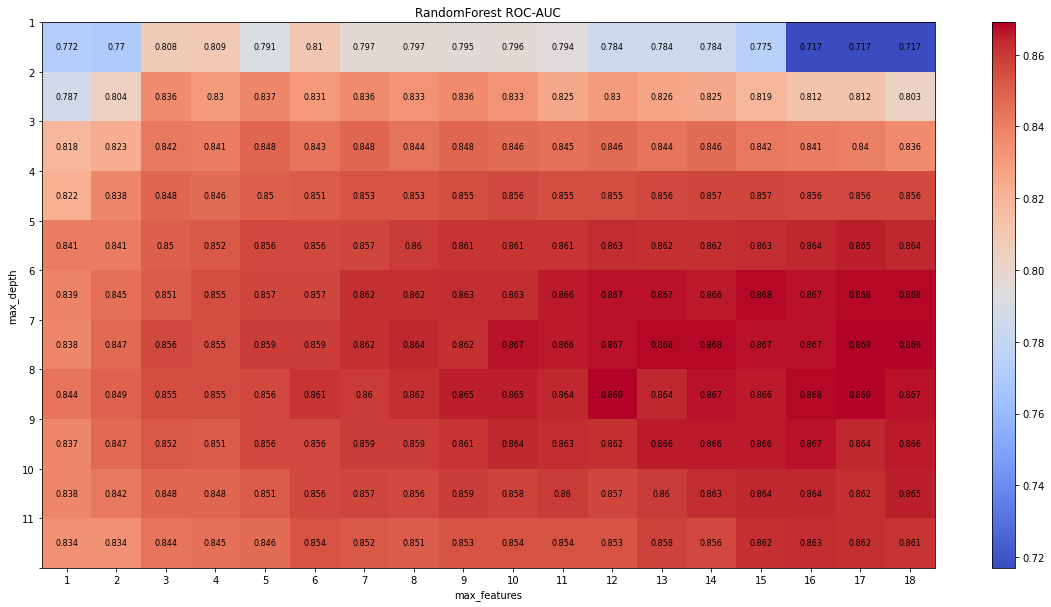

Best valid score: 0.869
Train score: 0.983
Best params: {'max_features': 17, 'max_depth': 7}


In [56]:
model = RandomForestClassifier(random_state=123, n_estimators=10)
params = {'max_depth': range(1,12), 'max_features': range(1,X_train.shape[1]+1)}
paramCV(model, train_data, params, name='RandomForest')

Теперь для лучшего варианта подберем оптимальное число деревьев.

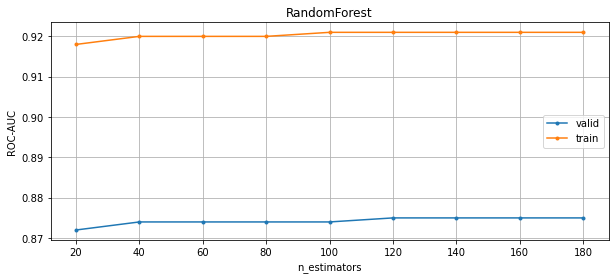

Best valid score: 0.875
Train score: 0.921
Best params: {'n_estimators': 120}


In [57]:
model = RandomForestClassifier(random_state=123, max_features=17, max_depth=7)
params = {'n_estimators': range(20,200,20)}
paramCV(model, train_data, params, name='RandomForest')

При 120 деревьях получен ROC-AUC 0,875. Неплохо. Теперь попробуем бустинг.

#### Градиентный бустинг LightGBM
Воспользуемся бустингом из библиотеки LightGBM. Проверим, какой результат получается "из коробки".

In [58]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123)
paramCV(model, train_data, name='LightGBM')
print_feature_importance(model, X_train)


Best valid score: 0.897
Train score: 0.975
                             importance
ContractAge                        1324
MonthlyCharges                      812
Gender_Male                         126
Partner_Yes                          80
Dependents_Yes                       70
DeviceProtection_Yes                 60
StreamingTV_Yes                      58
Type_Two year                        57
TechSupport_Yes                      55
OnlineSecurity_Yes                   55
StreamingMovies_Yes                  53
Type_One year                        52
OnlineBackup_Yes                     52
MultipleLines_Yes                    51
SeniorCitizen_Yes                    37
InternetService_Fiber optic          27
Phone                                17
InternetService_No                   14


Сразу получили отличный результат - 0,897. Впечатлает. Ради приличия исследуем влияние гиперпараметров, будем подбирать их по одному. Начнем с num_leaves, который играет ключевую роль в сложности модели, его уменьшение помогает бороться с переобучением.

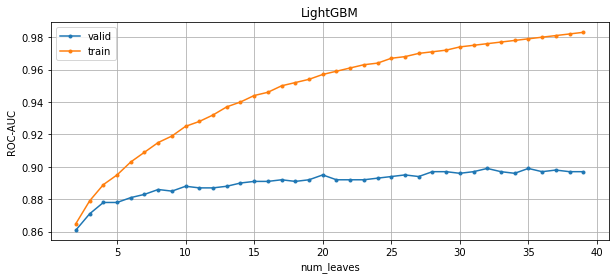

Best valid score: 0.899
Train score: 0.983
Best params: {'num_leaves': 32}


In [59]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123)
params = {'num_leaves': range(2,40)}
paramCV(model, train_data, params, name='LightGBM')

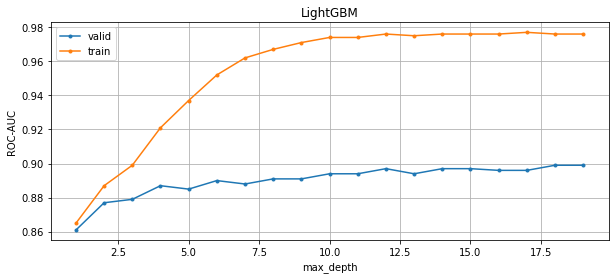

Best valid score: 0.899
Train score: 0.977
Best params: {'max_depth': 18}


In [60]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123,
                           num_leaves=32)
params = {'max_depth': range(1,20)}
paramCV(model, train_data, params, name='LightGBM')

Изменение остальных рекомендуемых гиперпараметров: min_data_in_leaf, learning_rate, max_bin, reg_alpha, reg_lambda относительно значений по умолчанию в данном случае ухудшает результат модели.  
Теперь, когда определены основные гиперпараметры, установим оптимальное количество итераций.

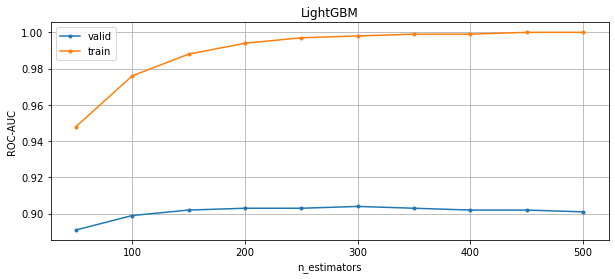

Best valid score: 0.904
Train score: 1.0
Best params: {'n_estimators': 300}


In [61]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123,
                           num_leaves=32)
params = {'n_estimators': range(50, 501, 50)}
paramCV(model, train_data, params, name='LightGBM')

Градиентный бустинг на 300 итерациях показал ROC-AUC выше 0,9. Рассматривать еще более сложные модели - нейронные сети - не вижу смысла.

Выведем таблицу с результатами разных моделей

In [62]:
result_table.sort_values('ROC-AUC', ascending=False)

,ROC-AUC
LightGBM,0.904
RandomForest,0.875
DecisionTree,0.854
LogisticRegression,0.848
LogisticRegression balanced,0.847
SVC,0.837
kNN,0.813


Все модели проходят проверку на адекватность, их значения ROC-AUC заметно выше 0,5. Результат улучшается с повышением сложности модели. Наилучший результат при кросс-валидации показал градиентный бустинг - 0,904.

## Тестирование модели
Для теста используем модель, градиентного бустинга с оптимальными значениями гиперпараметров, полученными в процессе кросс-валидации. Перед тем, как обучать модель, выполним нормализацию признаков обучающей и тестовой выборки.

In [63]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

In [64]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123, 
                           num_leaves=32, max_depth=18,
                           n_estimators=300)

model.fit(X_train, y_train)
predict = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]
print('Test ROC-AUC:', np.round(roc_auc_score(y_test, proba),3))
print('Test accuracy:', np.round(accuracy_score(y_test, predict),3))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, predict))

Test ROC-AUC: 0.906
Test accuracy: 0.851

Confusion matrix:
[[947  77]
 [132 248]]


Результат, полученый на тестовой выборке, даже немного превысил результат, полученный при кросс-валидации: с 0,904 ROC-AUC увеличился до 0,906. Предположу, что это произошло за счет увеличения обучающей выборки. Адекватность модели сомнению не подвергается, т.к. ROC-AUC значительно выше 0,5. Матрица ошибок также подтверждает, что модель научилась разделять классы.  
Задача выполнена, требуемый результат получен. 

## Вывод

Проведено исследование процесса ухода клиентов оператора связи «Ниединогоразрыва.ком».
Определены основные признаки, влияющие на вероятность ухода:
- срок, прошедший с момента заключения договора (чем больше, тем надежнее клиент);
- технология доступа в Интернет (оптоволокно - фактор риска);
- пользование только услугами телефонии (такие клиенты уходят редко);
- использование дополнительных услуг интернета: облачное хранилище, антивирус, блокировка сайтов (понижают вероятность ухода).

Абонентская плата также влияет на вероятность ухода, но, по всей видимости, как производная обозначенных выше признаков.

Построена модель, предсказывающая уход клиента.  
В ходе подбора модели были исследованы алгоритмы: логистическая регрессия, kNN, SVC, дерево решений, случайный лес, градиентный бустинг. Лучший результат на кросс-валидации был получен с использованием градиентного бустинга, на тестовой выборке он позволил получить значение ROC-AUC 0,906. Accuracy при этом составила 0,851.